## Evaluation of the Results 

This jupyter notebook contains the code to evaluate the simulation results obatined. 
1. Data for each Block is gathered 
2. Data for each Block is compared, measured, results, CVRMSE, e.g. 
3. Data is plotted for 

In [2]:
import os
import geopandas as gpd 
import matplotlib.pyplot as plt

<Axes: >

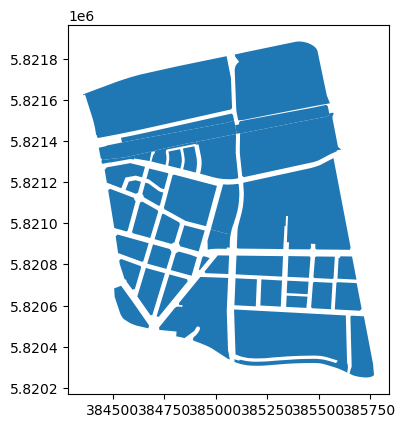

In [3]:
# Load Block level data 
block_data = gpd.read_file(r'auxillary\00_block_shape.shp')
block_data.plot()

In [4]:
# Load Building level data and shape file
CEA_shape_path = os.path.join('CEA_model', 'DefaultModel', '2020_GER_Updated', 'inputs', 'building-geometry' ,'zone.shp')
CEA_shape = gpd.read_file(CEA_shape_path)
CEA_shape.plot()

NameError: name 'os' is not defined

In [ ]:
CEA_shape = CEA_shape.to_crs(block_data.crs)

In [ ]:
# Perform spatial join to find which block each building in CEA_shape belongs to
buildings_with_block = gpd.sjoin(CEA_shape, block_data, how="inner", op='intersects')

# Filter by building Name (replace 'YourBuildingName' with the actual building name)
building_block = buildings_with_block[buildings_with_block['Name'] == 'B1000']

# Assuming 'blknr' is a column in block_data indicating the block number
block_number = building_block['blknr'].unique()

print(f"Building is in block number(s): {block_number}")

Building is in block number(s): ['020055']


c:\Users\felix\anaconda3\envs\cea\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [ ]:
# Gather CEA simulation results
import pandas as pd 
import os 

data_dict = {
    "QH_sys_MWhyr": {},
    "E_sys_MWhyr": {}
}
#C:\Users\felix\Documents\Programmieren\Mierendorff_CEA\CEA_model\DefaultModel\2020_GER_Updated\outputs\data\demand\B1000.csv
#CEA_model\\Default_Model2020_GER_Updated\\outputs\\data\\demand\\Total_demand.csv

QH_dict = {}
base_path = 'CEA_model/Block0202023'
block_numbers = list(block_data["blknr"])
# Gather CEA simulation results
import pandas as pd 
import os 

data_dict = {
    
}

block_numbers = list(block_data["blknr"])
# Initialize data_dict with keys for each year and energy type
data_dict = {
    'blknr': [],
    'QH_sys_MWhyr_2020': [],
    'QH_sys_MWhyr_2021': [],
    'QH_sys_MWhyr_2022': [],
    'E_sys_MWhyr_2020': [],
    'E_sys_MWhyr_2021': [],
    'E_sys_MWhyr_2022': []
}

block_numbers = list(block_data["blknr"])
for block_number in block_numbers:
    buildings_in_block = buildings_with_block[buildings_with_block['blknr'] == block_number]
    if buildings_in_block.empty:
            continue
    else:
         data_dict['blknr'].append(block_number)
         for year in [2020, 2021, 2022]:
            path = os.path.join('CEA_model', 'DefaultModel', f'{year}_GER_Updated', 'outputs', 'data', 'demand', 'Total_demand.csv')
            df = pd.read_csv(path)
            # Extract building names into a list
            building_names = buildings_in_block['Name'].tolist()  # Assuming 'Name' is the column with building names
            filtered_df = df[df['Name'].isin(building_names)]
            
            # Append the block number and aggregated values to their respective lists in data_dict
            
            data_dict[f"QH_sys_MWhyr_{year}"].append(filtered_df["QH_sys_MWhyr"].sum())
            data_dict[f"E_sys_MWhyr_{year}"].append(filtered_df["E_sys_MWhyr"].sum())


In [ ]:
# Assuming data_dict is already defined as per your previous instructions
simulation_data = pd.DataFrame(data_dict, columns=data_dict.keys())
simulation_merged_gdf = gpd.GeoDataFrame(pd.merge(block_data, simulation_data, on='blknr', how='left'))

In [ ]:
# Load measured data 
#auxillary\DistrictLevelData.csv
measured_data_path = os.path.join('auxillary', 'DistrictLevelData.csv')
measured_data = pd.read_csv(measured_data_path)
measured_data['blknr'] = measured_data['blknr'].astype(int)
block_data['blknr'] = block_data['blknr'].astype(int)
measured_merged_gdf = gpd.GeoDataFrame(pd.merge(block_data, measured_data, on='blknr', how='left'))
block_numbers_int = [int(x) for x in simulation_merged_gdf["blknr"]]
measured_merged_gdf = measured_merged_gdf[measured_merged_gdf["blknr"].isin(block_numbers_int)]
#block_data['blknr'] = block_data['blknr'].astype('int64') 
#elec_data = pd.read_excel(r'C:\Users\felix\Programmieren\tecdm\data\berlin\Elec_Berlin_2020_2022.xls')    
#elec_data["blknr"] = energy_data["Blocknummer"]
#elec_data_shapes = shape_data.merge(elec_data, on="blknr") 
#elec_data_shapes 

In [ ]:
from matplotlib.colors import Normalize



# Assuming simulation_merged_gdf and measured_merged_gdf are defined GeoDataFrames
# Calculate vmin and vmax for normalization across all plots
vmin = min(simulation_merged_gdf[["QH_sys_MWhyr_2020", "QH_sys_MWhyr_2021", "QH_sys_MWhyr_2022"]].min().min(),
           measured_merged_gdf[['dh_consumption_mwh2022', 'gas_consumption_mwh_2021', 'gas_consumption_mwh_2020']].min().min())
vmax = max(simulation_merged_gdf[["QH_sys_MWhyr_2020", "QH_sys_MWhyr_2021", "QH_sys_MWhyr_2022"]].max().max(),
           measured_merged_gdf[['gas_consumption_mwh_2022', 'gas_consumption_mwh_2021', 'gas_consumption_mwh_2020']].max().max())

# Define a normalization for the color mapping
norm = Normalize(vmin=vmin, vmax=vmax)

# Set up the figure for subplots (2 rows, 3 columns)
fig, axs = plt.subplots(2, 3, figsize=(20, 14))  # Adjusted to 2 rows


# Create the color map
cmap = plt.cm.viridis


# Plotting QH_sys_MWhyr 2020, 2021, 2022 in the first row
columns = ['QH_sys_MWhyr_2020', 'QH_sys_MWhyr_2021', 'QH_sys_MWhyr_2022']
for i, column in enumerate(columns):
    simulation_merged_gdf.plot(column=column, ax=axs[0, i], legend=True, cmap=cmap, norm=norm)
    axs[0, i].set_title(f'{column}')
    axs[0, i].axis('off')

# Plotting gas consumption for 2020, 2021, 2022 in the second row
columns = ['gas_consumption_mwh_2020', 'gas_consumption_mwh_2021', 'gas_consumption_mwh_2022']
for i, column in enumerate(columns):
    measured_merged_gdf.plot(column=column, ax=axs[1, i], legend=True, cmap=cmap, norm=norm)
    axs[1, i].set_title(f'{column}')
    axs[1, i].axis('off')

plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Adjust space between plots

# Add a common title
fig.suptitle('QH_sys_MWhyr & Gas Consumption per Block on the Mierendorffisland 2020 - 2022', fontsize=16)

# Adjust the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect to make room for the common title

NameError: name 'simulation_merged_gdf' is not defined